In [102]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/dtch1997/github/mcx-lab/rl-baselines3-zoo')

# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [103]:
import numpy as np
import pickle 
import json

def load_robot_states(stats_dir):
    base_rpy = np.load(stats_dir / 'base_rpy.npy')
    base_position = np.load(stats_dir / 'base_position.npy')
    base_velocity = np.load(stats_dir / 'base_velocity.npy')
    motor_position = np.load(stats_dir / 'motor_position.npy')
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    ref_displacement = np.load(stats_dir / 'reference_displacement.npy')
    act_displacement = np.load(stats_dir / 'actual_displacement.npy')
    ref_foot_contacts = np.load(stats_dir / 'reference_foot_contact.npy')
    act_foot_contacts = np.load(stats_dir / 'actual_foot_contact.npy')
    nn_observations = np.load(stats_dir / 'nn_observations.npy')

    reward_component_values = np.load(stats_dir / 'reward_components.npy')
    with open(stats_dir / 'reward_component_names.json', 'r') as file:
        reward_component_names = json.load(file)
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    time = np.load(stats_dir / 'time.npy')
    
    return {
        'time': time, 
        'base_rpy': base_rpy,
        'base_pos': base_position,
        'base_vel': base_velocity,
        'motor_pos': motor_position, 
        'motor_vel': motor_velocity, 
        'ref_displacement': ref_displacement,
        'act_displacement': act_displacement,
        'ref_foot_contacts': ref_foot_contacts, 
        'act_foot_contacts': act_foot_contacts, 
        'nn_obs': nn_observations,
        'nn_act': nn_actions,
        'reward_component_values': reward_component_values,
        'reward_component_names': reward_component_names
    }

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

In [104]:
model_dir = project_dir / 'logs' / 'ppo' / 'A1GymEnv-v0_44'
foot_names = ['FR', 'FL', 'RR', 'RL']

stats_dirs = [
    model_dir / 'trot-1.5Hz-0.5mps-stairs',
    model_dir / 'trot-2.0Hz-0.6mps-stairs',
    model_dir / 'trot-2.5Hz-0.8mps-stairs',
]

statss = [load_robot_states(sd) for sd in stats_dirs]
normalizer = load_normalizer(model_dir)

(1000, 1, 108)
(1000, 1, 108)
(1000, 1, 108)


# Plot Reference / Actual Foot Contacts

In [105]:
import matplotlib.pyplot as plt

google_blue = (66 / 256, 133 / 256, 244 / 256, 1)
google_orange = (219 / 256, 118 / 256, 55 / 256, 1)

foot_names = ['FR', 'FL', 'RR', 'RL']
foot_colors = [google_blue, google_blue, google_orange, google_orange]

def plot_foot_contacts(ax, time, foot_contacts, title):
    
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(foot_names)
    for i in range(4):
        # Select timesteps where foot is on ground
        ground_idx = foot_contacts[:,i] == 1
        foot_time = time[ground_idx]
        foot_fc = (i+1,) * foot_time.shape[0] # foot_names[i] * foot_time.shape[0]
        
        # ax.scatter(foot_time, foot_fc)
        ax.set_title(title)
        ax.axhline(y=i+0.5, color='black', linestyle='--')
        ax.fill_between(time, i-0.3, i+0.3, where=ground_idx, color = foot_colors[i])


0.8404099999999998
[37.5 37.5 37.5 37.5]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0.8473999999999998
[50.5 50.5 50.5 50.5]
0.8418899999999998
[64. 64. 64. 64.]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


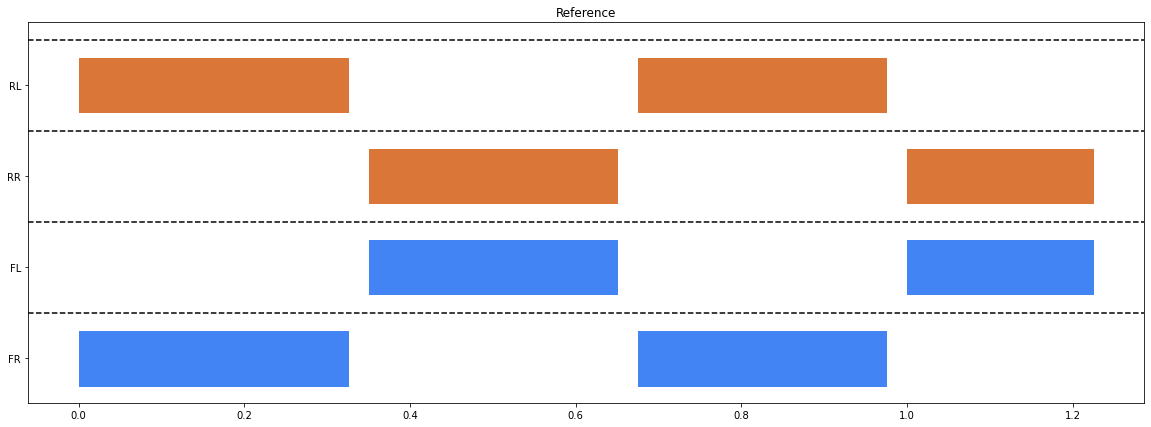

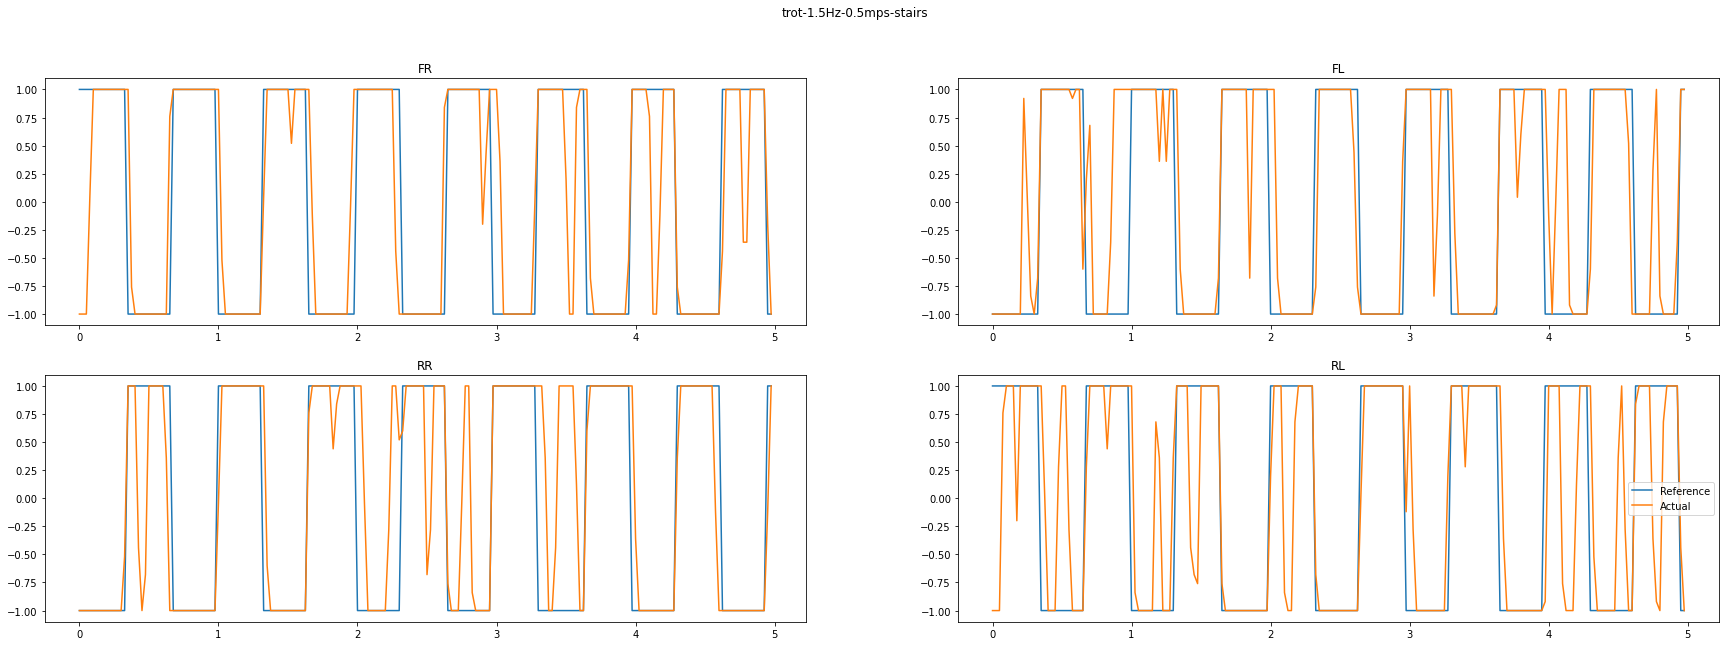

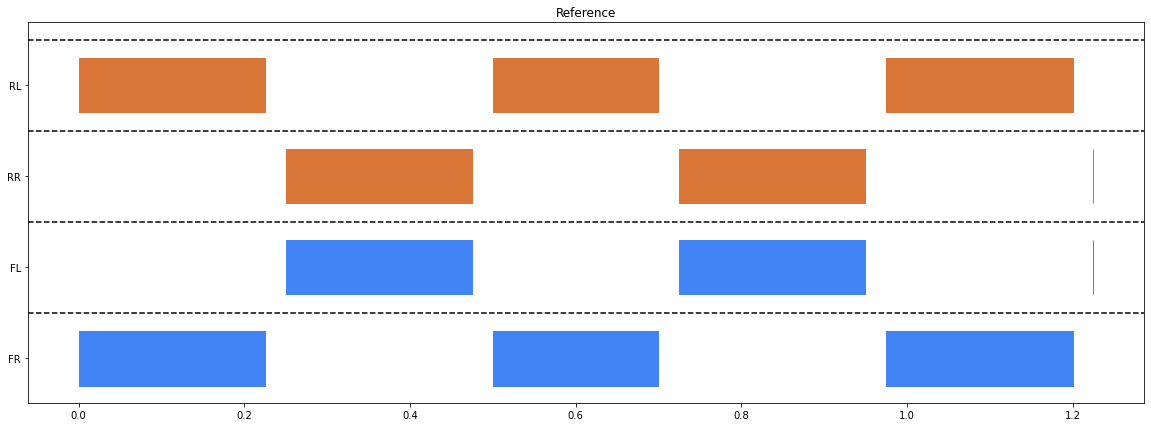

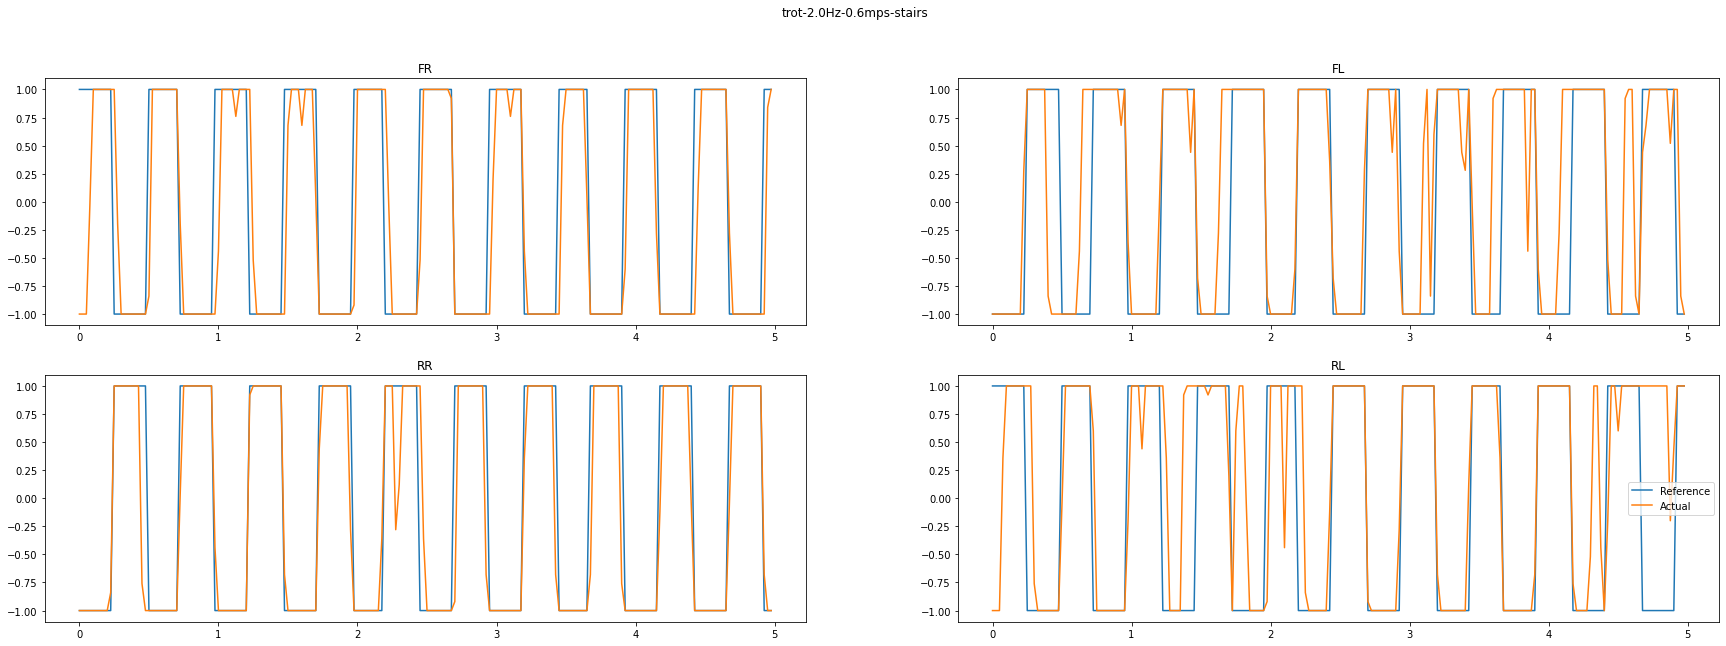

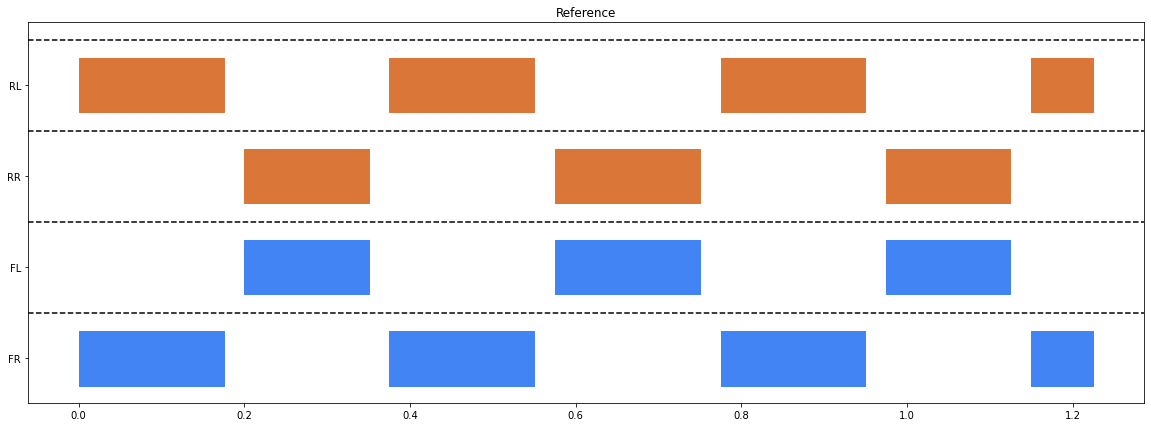

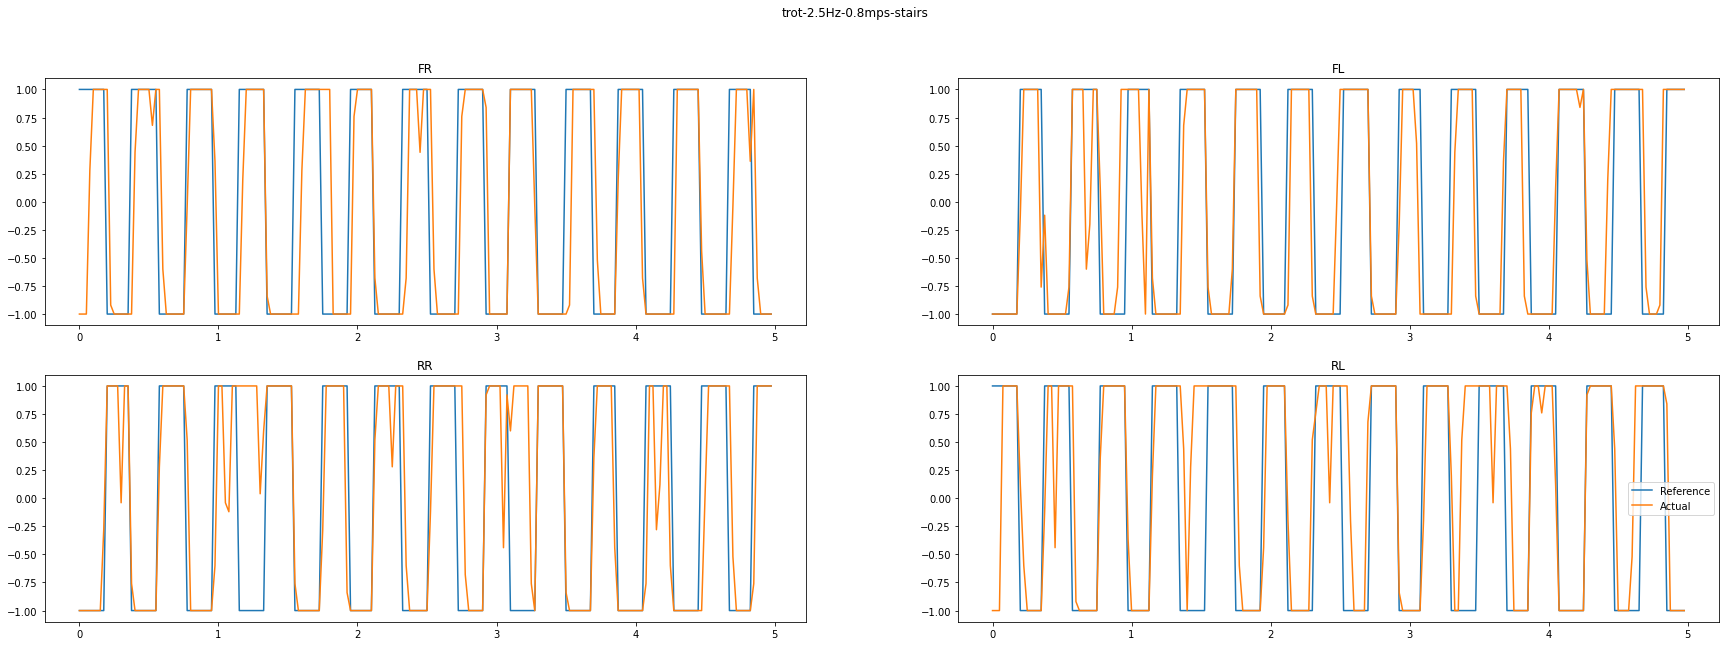

In [106]:
NUM_TIMESTEPS = 200

def calc_hamming_sim(stats, stats_dir):
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']

    # Divide by 2 since binary entries are [-1, 1] and not [0,1]
    diff = np.abs(ref_foot_contacts - act_foot_contacts) / 2
    hamming_dist = np.mean(diff)
    hamming_sim = 1 - hamming_dist
    print(hamming_sim)

def plot_foot_contact_sequence(stats, stats_dir):
    import matplotlib.pyplot as plt 
    
    time = stats['time']
    ref_foot_contacts = stats['ref_foot_contacts']
    act_foot_contacts = stats['act_foot_contacts']
    # Every cycle will result in an overall +4 to the absolute difference of consec. terms
    num_cycles = np.sum(np.abs(ref_foot_contacts[:-1] - ref_foot_contacts[1:]), axis=0) / 4
    print(num_cycles)
    
    fig, ax = plt.subplots(figsize=(20, 7))
    plot_foot_contacts(ax, time[:50], ref_foot_contacts[:50], "Reference")
    
    fig, ax = plt.subplots(2,2, figsize=(30,10))
    fig.suptitle(stats_dir.name)
    idxes = [(0,0), (0,1), (1,0), (1,1)]
    for i in range(4):
        ax[idxes[i]].set_title(f"{foot_names[i]}")
        ax[idxes[i]].plot(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, i], label = 'Reference')
        ax[idxes[i]].plot(time[:NUM_TIMESTEPS], act_foot_contacts[:NUM_TIMESTEPS, i], label = 'Actual')
        plt.legend()

for stats, stats_dir in zip(statss, stats_dirs):
    calc_hamming_sim(stats, stats_dir)
    plot_foot_contact_sequence(stats, stats_dir)
    

# Plot Base Position / Velocity vs reference Velocity

Roll mse: 0.11533384839982652
Pitch mse: 0.0964264954185243
Roll mse: 0.1231747612477974
Pitch mse: 0.09713577417672116
Roll mse: 0.10295175817902631
Pitch mse: 0.09030624774219775


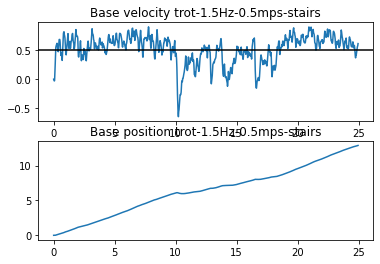

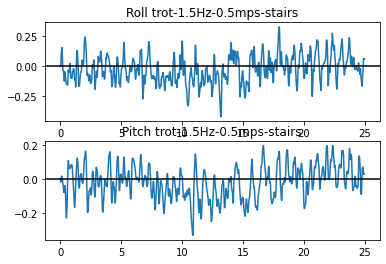

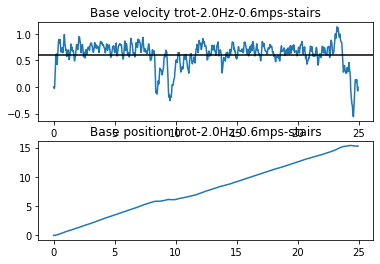

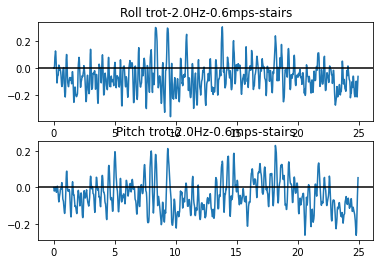

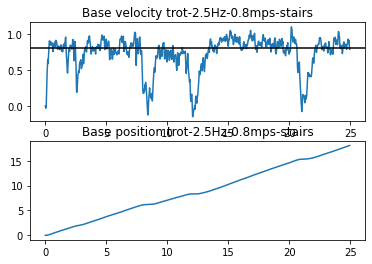

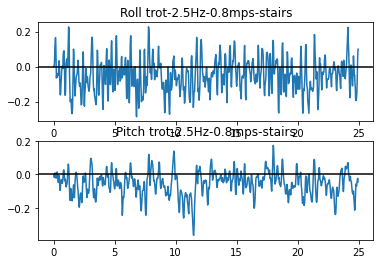

In [107]:
def plot_position_velocity(stats, stats_dir, target = None):
    time = stats['time']
    base_vel = stats['base_vel']
    base_pos = stats['base_pos']

    fig, ax = plt.subplots(2)
    ax[0].set_title(f"Base velocity {stats_dir.name}")
    ax[0].plot(time[:-1], base_vel[:-1, 0])
    if target: 
        ax[0].axhline(target, color='black')

    ax[1].set_title(f"Base position {stats_dir.name}")
    ax[1].plot(time[:-1], base_pos[:-1, 0])

def plot_roll_pitch(stats, stats_dir, target = None):
    time = stats['time']
    base_rpy = stats['base_rpy']

    fig, ax = plt.subplots(2)
    ax[0].set_title(f"Roll {stats_dir.name}")
    ax[0].plot(time[:-1], base_rpy[:-1, 0])
    ax[0].axhline(0,  color='black')

    roll_mse = np.sqrt(np.mean(base_rpy[:,0] ** 2, axis=0))
    print(f"Roll mse: {roll_mse}")

    ax[1].set_title(f"Pitch {stats_dir.name}")
    ax[1].plot(time[:-1], base_rpy[:-1, 1])
    ax[1].axhline(0,  color='black')

    pitch_mse = np.sqrt(np.mean(base_rpy[:,1] ** 2, axis=0))
    print(f"Pitch mse: {pitch_mse}")

targets = [0.5, 0.6, 0.8]
for i, (stats, stats_dir) in enumerate(zip(statss, stats_dirs)):
    plot_position_velocity(stats, stats_dir, target = targets[i])
    plot_roll_pitch(stats, stats_dir)

Total reward for distance: 316.13029373436814
Total reward for shake: -107.60701005493706
Total reward for energy: -4.469770447204171
Total reward for imitation: 679.8200000000002
Total reward for distance: 495.9277937998637
Total reward for shake: -112.55652078328865
Total reward for energy: -4.385982624908662
Total reward for imitation: 693.8000000000002
Total reward for distance: 601.2237925769059
Total reward for shake: -108.82390321678292
Total reward for energy: -4.095496020847143
Total reward for imitation: 683.0800000000003


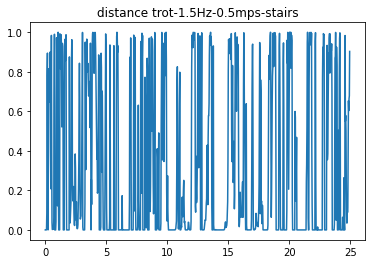

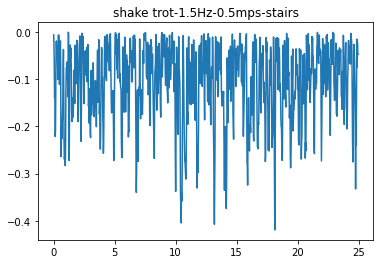

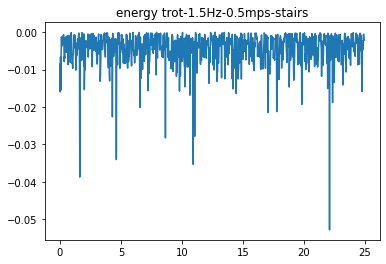

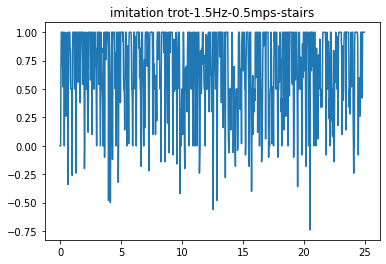

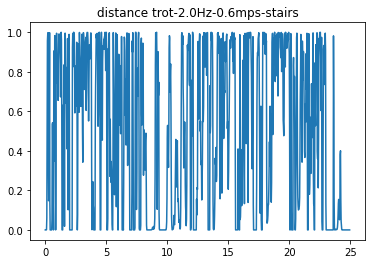

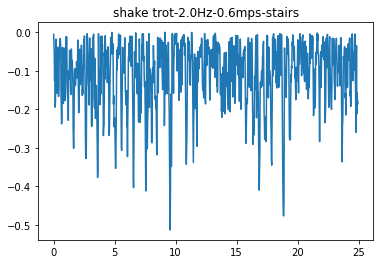

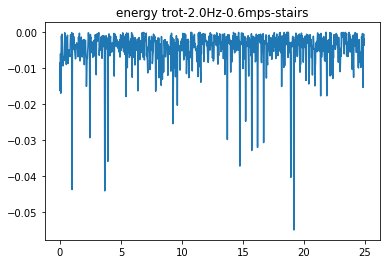

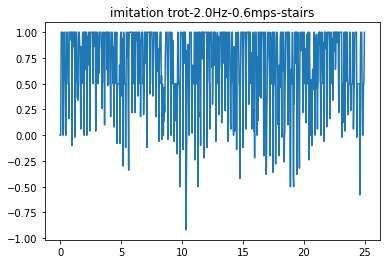

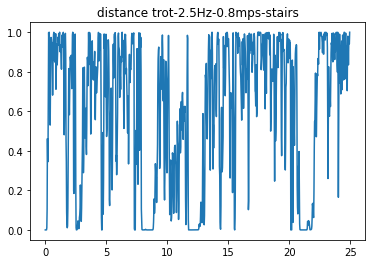

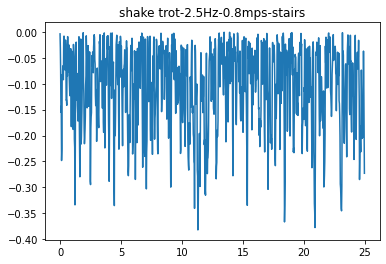

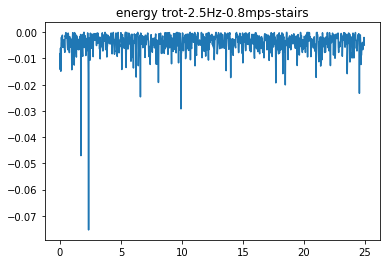

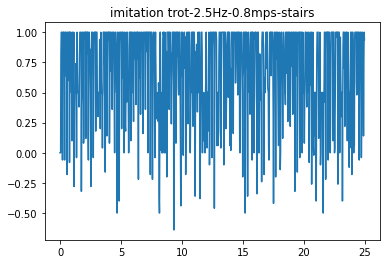

In [108]:
def plot_reward_components(stats, stats_dir):
    time = stats['time']
    reward_components_values = stats['reward_component_values']
    reward_components_names = stats['reward_component_names']

    for i, rew_comp_name in enumerate(reward_components_names):
        plt.figure()
        plt.title(f"{rew_comp_name} {stats_dir.name}")
        plt.plot(time[:-1], reward_components_values[:-1,i])

        print(f"Total reward for {rew_comp_name}: {reward_components_values[:-1,i].sum()}")

for stats, stats_dir in zip(statss, stats_dirs):
    plot_reward_components(stats, stats_dir)